In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from typing import Tuple
from scipy.special import logsumexp
from scipy.stats import norm
from skimage.metrics import structural_similarity as ssim

In [2]:
gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if gpu else "cpu")
print("device:", device)

device: cuda:0


In [3]:
batch_size = 128
log_interval = 10
torch.manual_seed(50)

In [4]:
# Tranformation that adds random uniform noise [0 - 1]
# to an iamge, which is done similairly to how they do it in the paper.
class AddNoiseToTensor(object):

    def __call__(self, pic):
        
        img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))
        nchannel = len(pic.mode)
        img = img.view(pic.size[1], pic.size[0], nchannel)
        img = img.transpose(0, 1).transpose(0, 2).contiguous()
        tensor = img.float()
        return ( tensor + torch.rand(tensor.size())).div(256.)

In [5]:
root = './data'
if not os.path.exists(root):
    os.mkdir(root)

if not os.path.exists('results'):
    os.mkdir('results')

kwargs = {'num_workers': 1, 'pin_memory': True} if device.type == "cuda:0" else {}
train_loader = DataLoader(
    datasets.MNIST(root, train=True, download=True,
                   transform=AddNoiseToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = DataLoader(
    datasets.MNIST(root, train=False, transform=AddNoiseToTensor()),
    batch_size=batch_size, shuffle=False, **kwargs)

In [6]:
## using the provided resource as base architecture
class VAE(nn.Module):
    def __init__(self, hidden_dims, data_dim=784, device=device):
        super().__init__()
        assert len(hidden_dims) == 5, "Insufficiently number of dimensions!"
        self.data_dim = data_dim
        self.device = device
        # define IO
        self.in_layer = nn.Linear(data_dim, hidden_dims[0])
        self.out_layer = nn.Linear(hidden_dims[-1], data_dim)
        # hidden layer
        self.enc_h = nn.Linear(hidden_dims[0], hidden_dims[1])
        # define hidden and latent
        self.enc_mu = nn.Linear(hidden_dims[1], hidden_dims[2])
        self.enc_sigma = nn.Linear(hidden_dims[1], hidden_dims[2])
        # hidden layer decoder
        self.dec_h = nn.Linear(hidden_dims[2], hidden_dims[-2])
        self.dec_layer = nn.Linear(hidden_dims[-2], hidden_dims[-1])
        self.to(device)
        
    def encode(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        h1 = F.relu(self.in_layer(x))
        h2 = F.relu(self.enc_h(h1))
        return self.enc_mu(h2), F.softplus(self.enc_sigma(h2))

    def reparameterize(self, mu: torch.Tensor, std: torch.Tensor) -> torch.Tensor:
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z: torch.Tensor) -> torch.Tensor:
        h3 = F.relu(self.dec_h(z))
        h4 = F.relu(self.dec_layer(h3))
        return torch.sigmoid(self.out_layer(h4))

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        mu, std = self.encode(x.view(-1, self.data_dim))
        z = self.reparameterize(mu, std)
        return self.decode(z), mu, 2. * torch.log(std)

In [7]:
# loss function for bernoulli
def loss(recon_x: torch.Tensor, x: torch.Tensor, mu: torch.Tensor, logvar: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    assert recon_x.shape[0] == x.shape[0] and recon_x.shape[-1] == x.shape[-1], "Shape Mismatch between reconstruction and x"
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction="sum")
    KLD = -1/2 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD, BCE, KLD # = -ELBO

In [8]:
# function to compute the log norm constant
def sumlogC(x , eps = 1e-5):
    '''
    Numerically stable implementation of 
    sum of logarithm of Continous Bernoulli
    constant C, using Taylor 2nd degree approximation
        
    Parameter
    ----------
    x : Tensor of dimensions (batch_size, dim)
        x takes values in (0,1)
    ''' 
    x = torch.clamp(x, eps, 1.-eps) 
    mask = torch.abs(x - 0.5).ge(eps)
    far = torch.masked_select(x, mask)
    close = torch.masked_select(x, ~mask)
    far_values =  torch.log( (torch.log(1. - far) - torch.log(far)).div(1. - 2. * far) )
    close_values = torch.log(torch.tensor((2.))) + torch.log(1. + torch.pow( 1. - 2. * close, 2)/3. )
    return far_values.sum() + close_values.sum()

# loss function for continuous bernoulli
def loss_cb(recon_x: torch.Tensor, x: torch.Tensor, mu: torch.Tensor, logvar: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    assert recon_x.shape[0] == x.shape[0] and recon_x.shape[-1] == x.shape[-1], "Shape Mismatch between reconstruction and x"
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    LOGC = sumlogC(recon_x)
    return BCE + KLD + LOGC, BCE, KLD # = -ELBO

In [9]:
def train(model: VAE, epoch: int, train_loader: torch.utils.data.DataLoader, loss: callable, log_interval: int=25) -> list:
    model.train()
    train_loss = 0.
    train_loss_vals = []
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.to(model.device)
        x = x.view(-1, 784)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(x)
        loss_val, ce, kld = loss(recon_batch, x, mu, logvar)
        loss_val.backward()
        train_loss += loss_val.item()
        train_loss_vals.append(loss_val.item())
        optimizer.step()
        if batch_idx % log_interval == 0:
            print(f"Train epoch={epoch} [{batch_idx*len(x)}/{len(train_loader.dataset)}]\t loss={loss_val.item() / len(x)}")
            print(f"BCE={ce} KLD={kld}")
    print(f"===> epoch={epoch} avrg.loss={train_loss/len(train_loader.dataset)}")
    return train_loss_vals

In [10]:
def test(model: VAE, epoch: int, test_loader: torch.utils.data.DataLoader, loss: callable) -> list:
    model.eval()
    test_loss = 0.
    test_loss_vals = []
    with torch.no_grad():
        for i, (x, _) in enumerate(test_loader):
            x = x.to(model.device)
            x = x.view(-1, 784)
            recon_batch, mu, logvar = model(x)
            test_loss_val, ce, kld = loss(recon_batch, x, mu, logvar)
            test_loss += test_loss_val.item()
            test_loss_vals.append(test_loss_val.item())
            # if i == 0: # TODO: do we want to persist images here?
            #     n = min(data.size(0), 8)
            #     comparison = torch.cat([x[:n], ])
    test_loss /= len(test_loader.dataset)
    print(f"===> Test loss={test_loss}")
    return test_loss_vals

In [11]:
EPOCHS = 100
model = VAE(hidden_dims=[500, 500, 20, 500, 500]) # NOTE: 20D latent space
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [12]:
# either train or load pre trained model
train = False
if train:
    train_loss_vals_total = []
    test_loss_vals_total = []
    for e in range(1, EPOCHS+1):
        train_loss_vals = train(model, epoch=e, train_loader=train_loader, loss=loss)
        test_loss_vals = test(model, epoch=e, test_loader=test_loader, loss=loss)
        train_loss_vals_total.append(train_loss_vals)
        test_loss_vals_total.append(test_loss_vals)
else:
    model.load_state_dict(torch.load('./trained_models/Bernoulli_VAE', map_location=device))

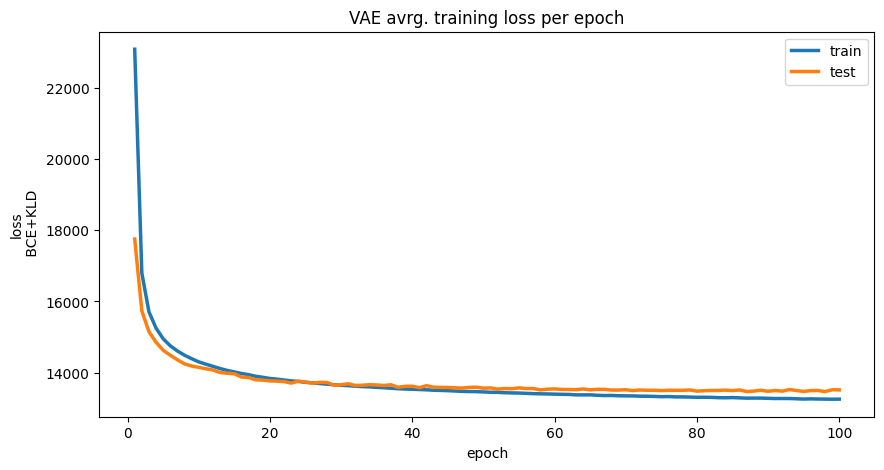

In [19]:
plt.plot(np.arange(1, EPOCHS+1), [np.mean(ls) for ls in train_loss_vals_total], lw=2.5, label="train")
plt.plot(np.arange(1, EPOCHS+1), [np.mean(ls) for ls in test_loss_vals_total], lw=2.5, label="test")
plt.xlabel("epoch")
plt.ylabel("loss\n BCE+KLD")
# plt.yscale("log")
plt.title("VAE avrg. training loss per epoch")
plt.legend()
plt.show()

In [13]:
model.eval()
with torch.no_grad():
        sample = torch.randn(64, 20).to(device)
        sample = model.decode(sample).cpu()
        #imshow(torchvision.utils.make_grid(sample[:16], 16 ))
        save_image(sample.view(64, 1, 28, 28),
                   'sample_' + 'VAE' + '.png')

In [14]:
EPOCHS = 100
model_cb = VAE(hidden_dims=[500, 500, 20, 500, 500]) # NOTE: 20D latent space
optimizer = optim.Adam(model_cb.parameters(), lr=1e-3)

In [15]:
if train:
    train_loss_vals_total = []
    test_loss_vals_total = []
    for e in range(1, EPOCHS+1):
        train_loss_vals = train(model_cb, epoch=e, train_loader=train_loader, loss=loss_cb)
        test_loss_vals = test(model_cb, epoch=e, test_loader=test_loader, loss=loss_cb)
        train_loss_vals_total.append(train_loss_vals)
        test_loss_vals_total.append(test_loss_vals)
else:
    model_cb.load_state_dict(torch.load('./trained_models/Continuous_Bernoulli_VAE', map_location=device))

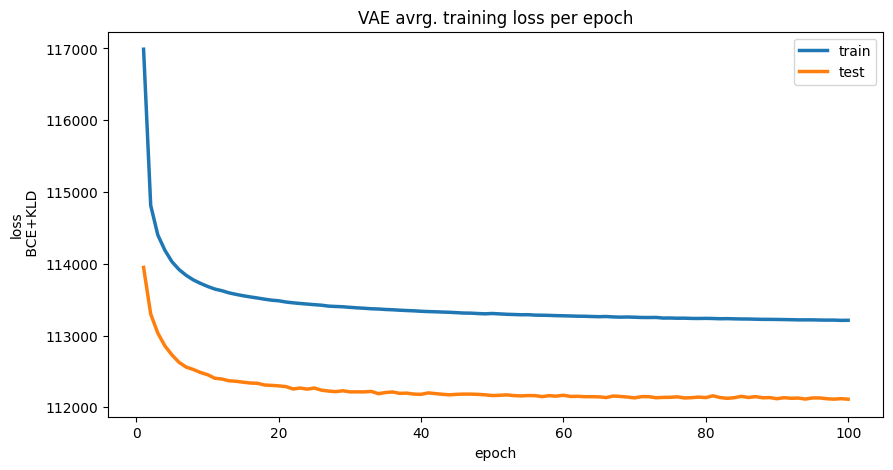

In [23]:
plt.plot(np.arange(1, EPOCHS+1), [np.mean(ls) for ls in train_loss_vals_total], lw=2.5, label="train")
plt.plot(np.arange(1, EPOCHS+1), [np.mean(ls) for ls in test_loss_vals_total], lw=2.5, label="test")
plt.xlabel("epoch")
plt.ylabel("loss\n BCE+KLD")
# plt.yscale("log")
plt.title("VAE avrg. training loss per epoch")
plt.legend()
plt.show()

In [13]:
# save the model
save_model = False

if save_model:
    model_path = './trained_models/Bernoulli_VAE'
    torch.save(model.state_dict(), model_path)

    model_path = './trained_models/Continuous_Bernoulli_VAE'
    torch.save(model_cb.state_dict(), model_path)

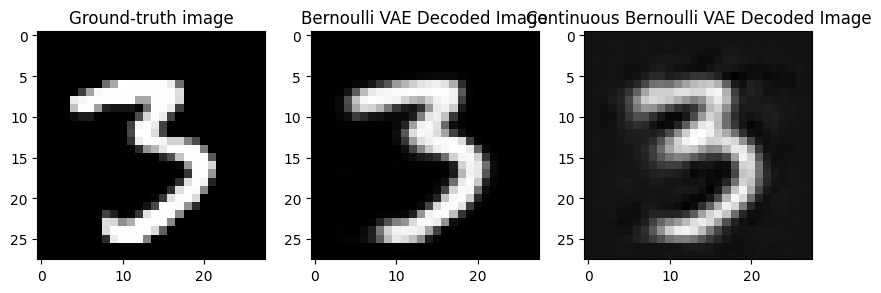

In [49]:
lst = []
for batch_idx, (x, _) in enumerate(train_loader):
    lst.append(x)
    break

idx = 5
img = lst[0][idx].view(28, 28)

model_img, _, _ = model.forward(lst[0][idx].to(device))
model_cb_img, _, _ = model_cb.forward(lst[0][idx].to(device))


f, axarr = plt.subplots(1,3)
axarr[0].imshow(img.detach().cpu().numpy(), cmap='gray')
axarr[0].set_title('Ground-truth image')
axarr[1].imshow(model_img.view(28, 28).detach().cpu().numpy(), cmap='gray')
axarr[1].set_title('Bernoulli VAE Decoded Image')
axarr[2].imshow(model_cb_img.view(28, 28).detach().cpu().numpy(), cmap='gray')
axarr[2].set_title('Continuous Bernoulli VAE Decoded Image')

plt.show()

In [33]:
def draw_sample_image(x, postfix):
  
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title("Visualization of {}".format(postfix))
    plt.imshow(torchvision.utils.make_grid(x.unsqueeze(1).detach().cpu(), padding=2, normalize=True).permute(1, 2, 0))

## Comparison between models

In [43]:
num_samples = 64
samples = torch.randn(size=(num_samples, 20)).to(device)

In [44]:
model_samples = model.decode(samples).view(-1, 28, 28)
model_cb_samples = model_cb.decode(samples).view(-1, 28, 28)

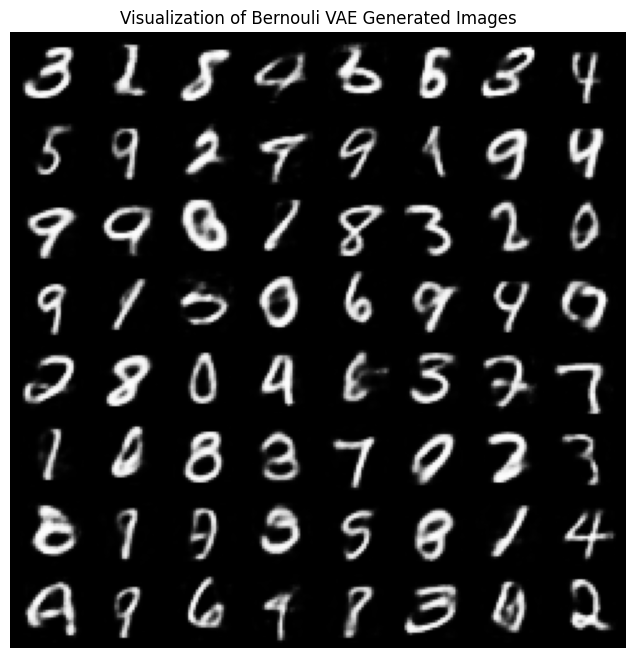

In [45]:
draw_sample_image(model_samples, "Bernouli VAE Generated Images")

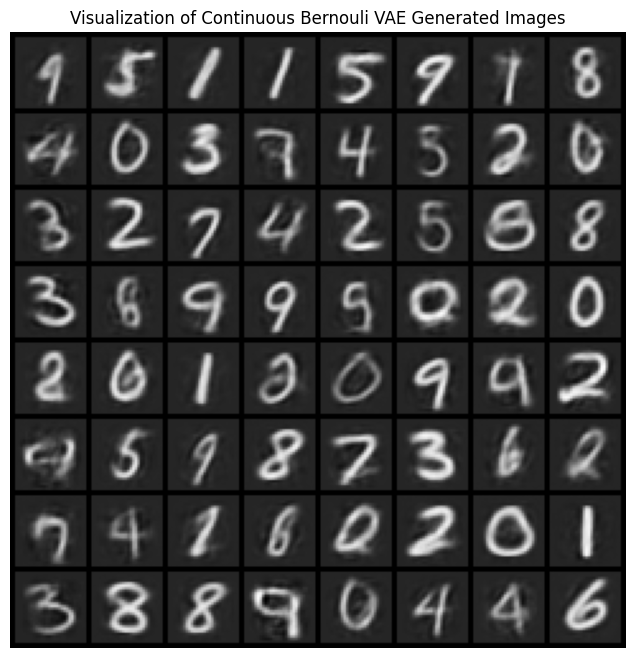

In [46]:
draw_sample_image(model_cb_samples, "Continuous Bernouli VAE Generated Images")

### Comparison using Structural Similarity Index Measure
- See https://scikit-image.org/docs/stable/auto_examples/transform/plot_ssim.html

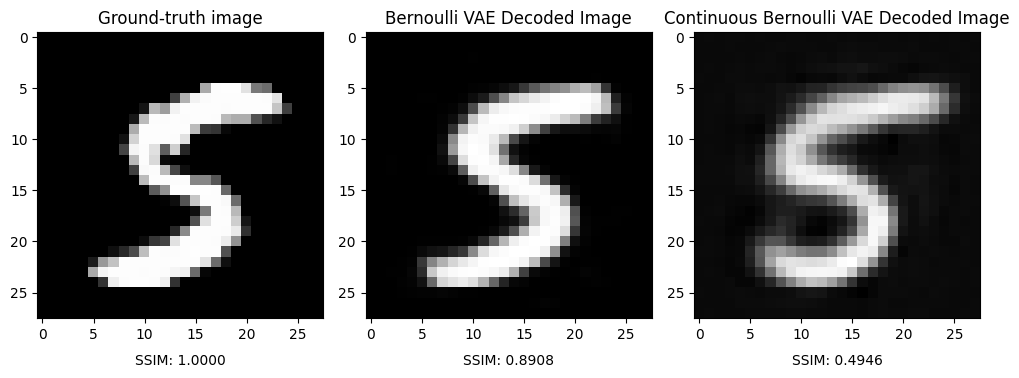

In [171]:
idx = 4
img = lst[0][idx].view(28, 28)

model_img, _, _ = model.forward(lst[0][idx].to(device))
model_cb_img, _, _ = model_cb.forward(lst[0][idx].to(device))

imm = img.detach().cpu().numpy()
imm2 = model_img.view(28, 28).detach().cpu().numpy()
imm3 = model_cb_img.view(28, 28).detach().cpu().numpy()


f, axarr = plt.subplots(1,3)
axarr[0].imshow(img.detach().cpu().numpy(), cmap='gray')
axarr[0].set_title('Ground-truth image')
axarr[1].imshow(model_img.view(28, 28).detach().cpu().numpy(), cmap='gray')
axarr[1].set_title('Bernoulli VAE Decoded Image')
axarr[2].imshow(model_cb_img.view(28, 28).detach().cpu().numpy(), cmap='gray')
axarr[2].set_title('Continuous Bernoulli VAE Decoded Image')

ssim0 = ssim(imm, imm, data_range=imm.max() - imm.min())
ssim1 = ssim(imm, imm2, data_range=imm.max() - imm.min())
ssim2 = ssim(imm, imm3, data_range=imm.max() - imm.min())

axarr[0].text(0.5, -0.15, f'SSIM: {ssim0:.4f}', ha='center', va='center', transform=axarr[0].transAxes)
axarr[1].text(0.5, -0.15, f'SSIM: {ssim1:.4f}', ha='center', va='center', transform=axarr[1].transAxes)
axarr[2].text(0.5, -0.15, f'SSIM: {ssim2:.4f}', ha='center', va='center', transform=axarr[2].transAxes)

plt.tight_layout()
plt.show()

### ELBO comparison

In [77]:
model.eval()
loss = []
train_loss = 0
for batch_idx, (x, _) in enumerate(train_loader):
    x = x.to(model.device)
    x = x.view(-1, 784)
    recon_batch, mu, logvar = model(x)
    loss_val, ce, kld = loss_cb(recon_batch, x, mu, logvar)
    train_loss += loss_val.item()
    loss.append(loss_val.item())

train_loss/len(train_loader.dataset)

1396.6902223958334

In [78]:
model_cb.eval()
loss = []
train_loss_cb = 0
for batch_idx, (x, _) in enumerate(train_loader):
    x = x.to(model_cb.device)
    x = x.view(-1, 784)
    recon_batch, mu, logvar = model_cb(x)
    loss_val, ce, kld = loss_cb(recon_batch, x, mu, logvar)
    train_loss_cb += loss_val.item()
    loss.append(loss_val.item())

train_loss_cb/len(train_loader.dataset)

884.78504921875

## Importance Sampling

In [207]:
train_data = []
for batch_idx, (x, _) in enumerate(train_loader):
    train_data.append(x)

# Concatenate along the batch dimension (dim=0)
train_data = torch.cat(train_data, dim=0)
train_data = train_data.squeeze(1).to(device)

In [227]:
def compute_samples(data, num_samples, m):
    """ Sample from importance distribution z_samples ~ q(z|X) and
        compute p(z_samples), q(z_samples) for importance sampling
    """
    z_mean, z_sigma = m.encode(data)
    z_mean = z_mean.detach().cpu().numpy()
    z_sigma = z_sigma.detach().cpu().numpy()
    z_samples = []
    qz = []
    
    for m, s in zip(z_mean, z_sigma):
        z_vals = [np.random.normal(m[i], s[i], num_samples)
                  for i in range(len(m))]
    
        qz_vals = [norm.pdf(z_vals[i], loc=m[i], scale=s[i])
                  for i in range(len(m))]
        z_samples.append(z_vals)
        qz.append(qz_vals)
    
    z_samples = np.array(z_samples)
    pz = norm.pdf(z_samples)
    qz = np.array(qz)
    
    
    z_samples = np.swapaxes(z_samples, 1, 2)
    pz = np.swapaxes(pz, 1, 2)
    qz = np.swapaxes(qz, 1, 2)
    
    return torch.from_numpy(z_samples).float(), pz, qz

In [228]:
# Calculate importance sample
# \log p(x) = E_p[p(x|z)]
# = \log(\int p(x|z) p(z) dz)
# = \log(\int p(x|z) p(z) / q(z|x) q(z|x) dz)
# = E_q[p(x|z) p(z) / q(z|x)]
# ~= \log(1/n * \sum_i p(x|z_i) p(z_i)/q(z_i))
# = \log p(x) = \log(1/n * \sum_i e^{\log p(x|z_i) + \log p(z_i) - \log q(z_i)})
# = \log p(x) = -\logn + \logsumexp_i(\log p(x|z_i) + \log p(z_i) - \log q(z_i))
# See: scipy.special.logsumexp

def estimate_logpx_batch(data, num_samples, m):
    z_samples, pz, qz = compute_samples(data.view(-1, 784), num_samples, m)

    result = []
    for i in range(len(data)):
        datum = data[i].detach().cpu().numpy().reshape(784)
        x_predict = m.decode(z_samples[i].to(device)).detach().cpu().numpy().reshape(-1, 784)
        x_predict = np.clip(x_predict, np.finfo(float).eps, 1. - np.finfo(float).eps)
        p_vals = pz[i]
        q_vals = qz[i]

        # \log p(x|z) = Binary cross entropy
        logp_xz = np.sum(datum * np.log(x_predict + 1e-10) + (1. - datum) * np.log(1.0 - x_predict + 1e-10), axis=-1)
        logpz = np.sum(np.log(p_vals), axis=-1)
        logqz = np.sum(np.log(q_vals), axis=-1)
        argsum = logp_xz + logpz - logqz
        logpx = -np.log(num_samples) + logsumexp(argsum)
        result.append(logpx)
            
    return np.array(result)


def estimate_logpx_batch_cb(data, num_samples, m):
    z_samples, pz, qz = compute_samples(data.view(-1, 784), num_samples, m)
    
    result = []
    for i in range(len(data)):
        datum = data[i].detach().cpu().numpy().reshape(784)
        x_predict = m.decode(z_samples[i].to(device)).detach().cpu().numpy().reshape(-1, 784)
        x_predict = np.clip(x_predict, np.finfo(float).eps, 1. - np.finfo(float).eps)
        p_vals = pz[i]
        q_vals = qz[i]

        # \log p(x|z) = Binary cross entropy + log_constant
        # we add 1e-10 for numerical stability
        logp_xz = np.sum(datum * np.log(x_predict + 1e-10) + (1. - datum) * np.log(1.0 - x_predict + 1e-10), axis=-1)
        logp_xz = logp_xz + sumlogC(torch.from_numpy(x_predict)).detach().cpu().numpy()
        logpz = np.sum(np.log(p_vals), axis=-1)
        logqz = np.sum(np.log(q_vals), axis=-1)
        argsum = logp_xz + logpz - logqz
        logpx = -np.log(num_samples) + logsumexp(argsum)
        result.append(logpx)
            
    return np.array(result)

In [229]:
def estimate_logpx(data, num_samples, m, verbosity=0, cb=False):
    batches = []
    iterations = int(np.ceil(1. * len(data) / batch_size))
    for b in range(iterations):
        batch_data = data[b * batch_size:(b+1) * batch_size]
        if cb:
            batches.append(estimate_logpx_batch_cb(batch_data, num_samples, m))
        else:
            batches.append(estimate_logpx_batch(batch_data, num_samples, m))
        if verbosity and b % max(11 - verbosity, 1) == 0:
            print("Batch %d [%d, %d]: %.2f" % (b, b*batch_size, (b+1) * batch_size, 
                                               np.mean(np.concatenate(batches))))
            np.mean(np.concatenate(batches))        
    return np.mean(np.concatenate(batches))

num_samples = 256

logpx = estimate_logpx(train_data, num_samples, model, verbosity=1, cb=False)
print("log p(x) = %.2f" % logpx)

Batch 0 [0, 128]: -102.79
Batch 10 [1280, 1408]: -100.40
Batch 20 [2560, 2688]: -100.05
Batch 30 [3840, 3968]: -99.77
Batch 40 [5120, 5248]: -99.98
Batch 50 [6400, 6528]: -99.83
Batch 60 [7680, 7808]: -99.84
Batch 70 [8960, 9088]: -99.71
Batch 80 [10240, 10368]: -99.77
Batch 90 [11520, 11648]: -99.89
Batch 100 [12800, 12928]: -99.88
Batch 110 [14080, 14208]: -99.88
Batch 120 [15360, 15488]: -99.85
Batch 130 [16640, 16768]: -99.86
Batch 140 [17920, 18048]: -99.93
Batch 150 [19200, 19328]: -99.88
Batch 160 [20480, 20608]: -99.90
Batch 170 [21760, 21888]: -99.95
Batch 180 [23040, 23168]: -99.94
Batch 190 [24320, 24448]: -99.85
Batch 200 [25600, 25728]: -99.84
Batch 210 [26880, 27008]: -99.86
Batch 220 [28160, 28288]: -99.88
Batch 230 [29440, 29568]: -99.88
Batch 240 [30720, 30848]: -99.85
Batch 250 [32000, 32128]: -99.88
Batch 260 [33280, 33408]: -99.89
Batch 270 [34560, 34688]: -99.87
Batch 280 [35840, 35968]: -99.84
Batch 290 [37120, 37248]: -99.88
Batch 300 [38400, 38528]: -99.90
Batch

In [211]:
logpx = estimate_logpx(train_data, num_samples, model_cb, verbosity=1, cb=True)
print("log p(x) = %.2f" % logpx)

Batch 0 [0, 128]: 164490.69
Batch 10 [1280, 1408]: 164575.18
Batch 20 [2560, 2688]: 164604.58
Batch 30 [3840, 3968]: 164605.28
Batch 40 [5120, 5248]: 164589.41
Batch 50 [6400, 6528]: 164589.52
Batch 60 [7680, 7808]: 164585.73
Batch 70 [8960, 9088]: 164592.99
Batch 80 [10240, 10368]: 164592.35
Batch 90 [11520, 11648]: 164589.59
Batch 100 [12800, 12928]: 164592.26
Batch 110 [14080, 14208]: 164593.34
Batch 120 [15360, 15488]: 164590.48
Batch 130 [16640, 16768]: 164589.01
Batch 140 [17920, 18048]: 164586.32
Batch 150 [19200, 19328]: 164588.08
Batch 160 [20480, 20608]: 164585.38
Batch 170 [21760, 21888]: 164584.56
Batch 180 [23040, 23168]: 164585.84
Batch 190 [24320, 24448]: 164590.15
Batch 200 [25600, 25728]: 164592.57
Batch 210 [26880, 27008]: 164592.51
Batch 220 [28160, 28288]: 164591.32
Batch 230 [29440, 29568]: 164591.42
Batch 240 [30720, 30848]: 164593.47
Batch 250 [32000, 32128]: 164591.68
Batch 260 [33280, 33408]: 164590.45
Batch 270 [34560, 34688]: 164591.11
Batch 280 [35840, 35968

In [355]:
def constant(lambda_, eps=1e-5):
    c = 2. * torch.arctanh(1. - 2. * lambda_) / (1. - 2. * lambda_)

    return c

def logConstant(x):
    if abs(x - 0.5) < 1e-3:
        val = torch.log(torch.tensor(2))
        v = 1. - 2. * x
        v_squared = v ** 2
        taylor = 1
        e = 1
        for i in range(1, 10):
            e *= v_squared
            taylor += e / (2. * i + 1)
        return val + torch.log(taylor)
    return torch.log(constant(x))

In [251]:
l = torch.tensor(0.499)
print(torch.log(constant(l)))
print(logConstant(l))

l = torch.tensor(0.5-1e-17)
print(torch.log(constant(l)))
print(logConstant(l))

tensor(0.6931)
tensor(0.6931)
tensor(nan)
tensor(0.6931)
